In [5]:
#前置作業 : 各種import、設定SEED

In [6]:
%%capture
"""
在Python中，%%capture 是一個魔術命令（Magic Command），用於捕獲並抑制輸出。
比如說，這樣寫的話下面安裝的過程就會被隱藏。
"""
!pip install geopandas folium

In [7]:
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5}'.format #小數點後保留5位
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # You can ignore the Shapely GEOS warning :-)

In [8]:
#set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [9]:
#Loading and previewing data

In [10]:
DATA_PATH = 'D:/kaggle/input4'
#Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

#Preview train dataset
train.head()

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-0.510_29.290_2019_00     -0.51      29.29  2019        0   
1  ID_-0.510_29.290_2019_01     -0.51      29.29  2019        1   
2  ID_-0.510_29.290_2019_02     -0.51      29.29  2019        2   
3  ID_-0.510_29.290_2019_03     -0.51      29.29  2019        3   
4  ID_-0.510_29.290_2019_04     -0.51      29.29  2019        4   

   SulphurDioxide_SO2_column_number_density  \
0                               -0.00010834   
1                                2.0527e-05   
2                                0.00051414   
3                                       NaN   
4                               -7.8766e-05   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                       0.60302   
1                                       0.72821   
2                                        0.7482   
3                                           NaN   
4                                        0.6763   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                     -6.5331e-05   
1                                       1.361e-05   
2                                      0.00038468   
3                                             NaN   
4                                     -4.7624e-05   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                        0.25567                              -98.594  ...   
1                        0.13099                               16.593  ...   
2                        0.11002                               72.796  ...   
3                            NaN                                  NaN  ...   
4                        0.12116                               4.1213  ...   

   Cloud_cloud_top_height  Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0                  3664.4                 6.1086e+04                   2615.1   
1                  3651.2                 6.6969e+04                   3174.6   
2                  4217.0                 6.0069e+04                   3516.3   
3                  5228.5                 5.1065e+04                   4181.0   
4                  3980.6                 6.3751e+04                   3355.7   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                     15.569               0.27229   
1                     8.6906               0.25683   
2                     21.103                0.2511   
3                     15.387               0.26204   
4                     8.1147               0.23585   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                     -12.629                     35.632   
1                      30.359                     39.558   
2                      15.378                     30.402   
3                     -11.293                      24.38   
4                      38.532                     37.393   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  emission  
0                    -138.79                    30.752     3.751  
1                    -145.18                    27.252    4.0252  
2                    -142.52                    26.193    4.2314  
3                    -132.67                    28.829    4.3053  
4                    -141.51                    22.205    4.3473  

[5 rows x 76 columns]

In [11]:
test.head()

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-0.510_29.290_2022_00     -0.51      29.29  2022        0   
1  ID_-0.510_29.290_2022_01     -0.51      29.29  2022        1   
2  ID_-0.510_29.290_2022_02     -0.51      29.29  2022        2   
3  ID_-0.510_29.290_2022_03     -0.51      29.29  2022        3   
4  ID_-0.510_29.290_2022_04     -0.51      29.29  2022        4   

   SulphurDioxide_SO2_column_number_density  \
0                                       NaN   
1                                0.00045592   
2                                0.00016056   
3                                0.00034998   
4                               -0.00031696   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                           NaN   
1                                       0.69116   
2                                       0.60511   
3                                       0.69692   
4                                       0.58053   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                             NaN   
1                                      0.00031558   
2                                      0.00010582   
3                                      0.00024311   
4                                       -0.000184   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                            NaN                                  NaN  ...   
1                            0.0                               76.239  ...   
2                        0.07987                              -42.055  ...   
3                        0.20103                                72.17  ...   
4                        0.20435                               76.191  ...   

   Cloud_cloud_top_pressure  Cloud_cloud_top_height  \
0                3.6022e+04                  8472.3   
1                 4.854e+04                  6476.1   
2                3.4133e+04                  8984.8   
3                5.0855e+04                  6014.7   
4                4.6595e+04                  6849.3   

   Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0                 4.1048e+04                   7472.3   
1                 5.4916e+04                   5476.1   
2                 3.9006e+04                   7984.8   
3                 5.7646e+04                   5014.7   
4                 5.2897e+04                   5849.3   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                     7.9356               0.24077   
1                     11.448               0.29312   
2                     10.753               0.26713   
3                     11.765               0.30468   
4                     13.065               0.28422   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                     -100.11                     33.697   
1                      -30.51                     42.403   
2                      39.087                     45.936   
3                     -24.465                      42.14   
4                     -12.908                     30.123   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  
0                    -133.05                     33.78  
1                    -138.63                    31.012  
2                    -144.78                    26.743  
3                    -135.03                    29.605  
4                     -135.5                    26.277  

[5 rows x 75 columns]

In [12]:
samplesubmission.head()

ID_LAT_LON_YEAR_WEEK  emission
0  ID_-0.510_29.290_2022_00     81.94
1  ID_-0.510_29.290_2022_01     81.94
2  ID_-0.510_29.290_2022_02     81.94
3  ID_-0.510_29.290_2022_03     81.94
4  ID_-0.510_29.290_2022_04     81.94

In [13]:
train.shape, test.shape, samplesubmission.shape

((79023, 76), (24353, 75), (24353, 2))

In [14]:
#Train to test sets ratio
(test.shape[0])/(train.shape[0]+test.shape[0])

0.23557692307692307

In [15]:
#Statistical summaries

In [16]:
#Train statistical summary
train.describe(include = 'all')

ID_LAT_LON_YEAR_WEEK   latitude  longitude       year    week_no  \
count                      79023 7.9023e+04 7.9023e+04 7.9023e+04 7.9023e+04   
unique                     79023        NaN        NaN        NaN        NaN   
top     ID_-0.510_29.290_2019_00        NaN        NaN        NaN        NaN   
freq                           1        NaN        NaN        NaN        NaN   
mean                         NaN    -1.8911      29.88     2020.0       26.0   
std                          NaN    0.69452    0.81038     0.8165     15.297   
min                          NaN     -3.299     28.228     2019.0        0.0   
25%                          NaN     -2.451     29.262     2019.0       13.0   
50%                          NaN     -1.882     29.883     2020.0       26.0   
75%                          NaN     -1.303     30.471     2021.0       39.0   
max                          NaN      -0.51     31.532     2021.0       52.0   

        SulphurDioxide_SO2_column_number_density  \
count                                 6.4414e+04   
unique                                       NaN   
top                                          NaN   
freq                                         NaN   
mean                                  4.7882e-05   
std                                   0.00027203   
min                                  -0.00099624   
25%                                  -9.5833e-05   
50%                                   2.3694e-05   
75%                                   0.00015305   
max                                    0.0041906   

        SulphurDioxide_SO2_column_number_density_amf  \
count                                     6.4414e+04   
unique                                           NaN   
top                                              NaN   
freq                                             NaN   
mean                                         0.83485   
std                                          0.18538   
min                                          0.24182   
25%                                          0.70582   
50%                                          0.80912   
75%                                          0.94279   
max                                           1.8852   

        SulphurDioxide_SO2_slant_column_number_density  \
count                                       6.4414e+04   
unique                                             NaN   
top                                                NaN   
freq                                               NaN   
mean                                        3.5049e-05   
std                                         0.00020559   
min                                        -0.00088714   
25%                                        -7.7857e-05   
50%                                         1.8628e-05   
75%                                         0.00012068   
max                                          0.0042363   

        SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
count                      6.4414e+04                           6.4414e+04   
unique                            NaN                                  NaN   
top                               NaN                                  NaN   
freq                              NaN                                  NaN   
mean                          0.15842                              -7.9259   
std                          0.071364                               64.263   
min                               0.0                              -179.54   
25%                           0.11053                              -56.782   
50%                           0.16185                              -12.442   
75%                           0.21182                                72.06   
max                               0.3                                122.1   

        ...  Cloud_cloud_top_height  Cloud_cloud_base_pressure  \
count   ...              7.8539e+04                 7

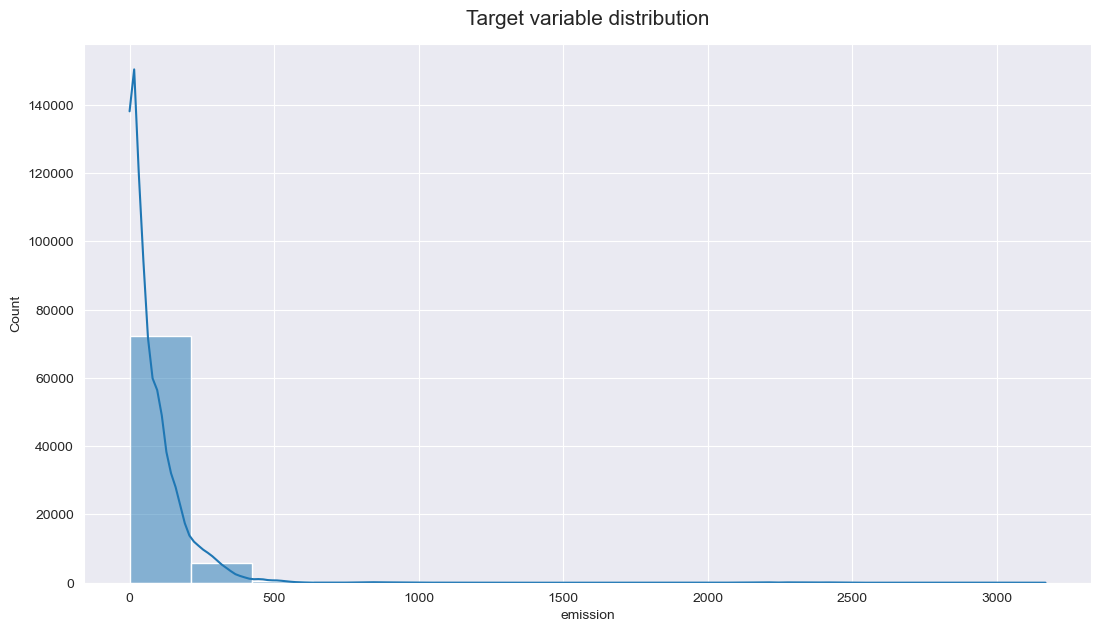

None

10.173825825101622

In [17]:
#Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15) #KDE(核密度估計)就是把長條圖畫成折線圖而已
#KDE的優點就是摺線圖彼長條途更好做比較
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

In [18]:
#Outliers

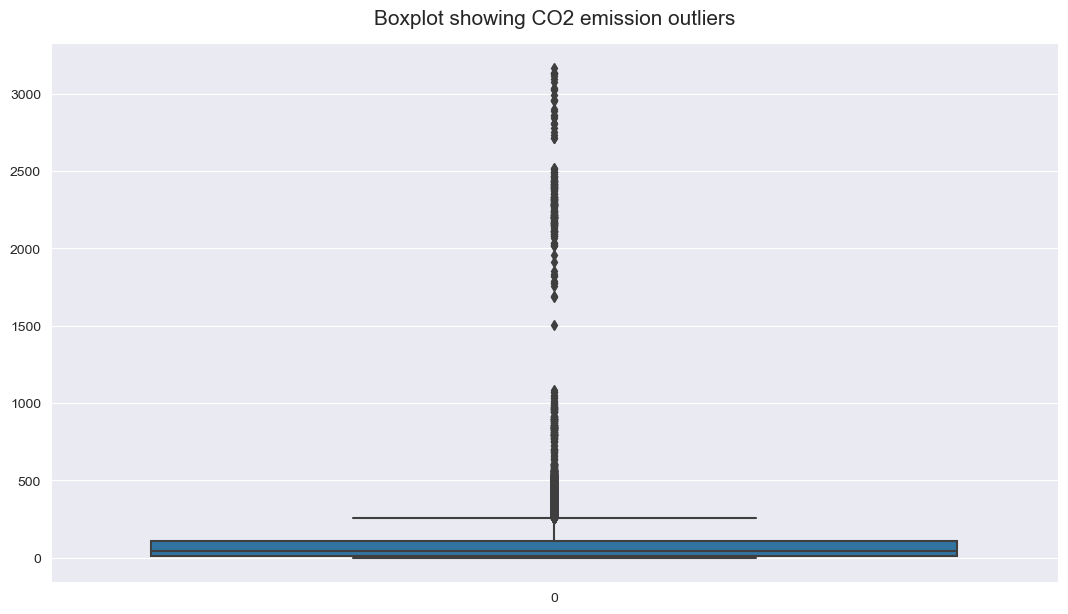

In [19]:
#Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13,7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)
plt.show()

In [20]:
"""
Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:

Transforming the outliers by scaling - log transformation, box-cox transformation ...
Dropping outliers
Imputation by replacing outliers with mean, median ...
"""

'\nOutliers are those data points which differ significantly from other observations present in given dataset.\n\nSuggestions on how to handle outliers:\n\nTransforming the outliers by scaling - log transformation, box-cox transformation ...\nDropping outliers\nImputation by replacing outliers with mean, median ...\n'

In [21]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude']) #drop_duplicate 去掉重複出現的經緯度
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude']) #drop_duplicate 去掉重複出現的經緯度
train_coords['set_type'], test_coords['set_type'] = 'train', 'test' #這裡添加了一個欄set_type，表示數據是訓練集還是測試集。

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
#create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(all_data[["latitude", "longitude", "set_type"]], geometry = geometry)

# Preview the geopandas df
geo_df.head()

latitude  longitude set_type                   geometry
0     -0.51      29.29    train  POINT (29.29000 -0.51000)
1    -0.528     29.472    train  POINT (29.47200 -0.52800)
2    -0.547     29.653    train  POINT (29.65300 -0.54700)
3    -0.569     30.031    train  POINT (30.03100 -0.56900)
4    -0.598     29.102    train  POINT (29.10200 -0.59800)

In [22]:
"""
Q. 這裡的geometry是幹嘛的?
Ans. 在這段程式碼中，geometry 是用來創建地理點幾何（geometric points）的一個重要變數。程式碼的主要目的是將訓練數據和測試數據中的經緯度座標（latitude 和 longitude）轉換成地理點的幾何表示，然後將這些地理點與其他相關數據一起放入 GeoDataFrame（一種用於處理地理數據的 Pandas DataFrame 的擴展）。以下是詳細說明：

train_coords 和 test_coords：將訓練數據和測試數據分別按照經緯度座標去重，因為可能有相同的經緯度出現多次。

all_data：將處理過的訓練和測試數據合併成一個新的 DataFrame，並在其中添加了一個列 set_type，表示數據是訓練集還是測試集。

geometry：這個變數創建了地理點的幾何表示，使用 gpd.points_from_xy 函式將經緯度座標轉換為點的幾何表示。

geo_df：使用 GeoDataFrame 創建了一個地理數據框，包含了原始的經緯度座標數據、set_type 列，以及前面創建的 geometry 列，這個列存儲了地理點的幾何表示。

總之，geometry 在這個上下文中是用來創建地理點的幾何表示，以便於將經緯度座標數據轉換為地理數據，並進一步進行地理空間分析和可視化。

"""
#我的想法是 : 要把圖用gis的工具畫出來，首先經緯度資料必須先轉成"幾何表示"。

'\nQ. 這裡的geometry是幹嘛的?\nAns. 在這段程式碼中，geometry 是用來創建地理點幾何（geometric points）的一個重要變數。程式碼的主要目的是將訓練數據和測試數據中的經緯度座標（latitude 和 longitude）轉換成地理點的幾何表示，然後將這些地理點與其他相關數據一起放入 GeoDataFrame（一種用於處理地理數據的 Pandas DataFrame 的擴展）。以下是詳細說明：\n\ntrain_coords 和 test_coords：將訓練數據和測試數據分別按照經緯度座標去重，因為可能有相同的經緯度出現多次。\n\nall_data：將處理過的訓練和測試數據合併成一個新的 DataFrame，並在其中添加了一個列 set_type，表示數據是訓練集還是測試集。\n\ngeometry：這個變數創建了地理點的幾何表示，使用 gpd.points_from_xy 函式將經緯度座標轉換為點的幾何表示。\n\ngeo_df：使用 GeoDataFrame 創建了一個地理數據框，包含了原始的經緯度座標數據、set_type 列，以及前面創建的 geometry 列，這個列存儲了地理點的幾何表示。\n\n總之，geometry 在這個上下文中是用來創建地理點的幾何表示，以便於將經緯度座標數據轉換為地理數據，並進一步進行地理空間分析和可視化。\n\n'

In [23]:
# Create a canvas to plot your map on
#這裡用Folium庫創建一個可互動的地圖，用canvas 引擎驅動
all_data_map = folium.Map(prefer_canvas=True) 

#Create a geometry list from the GeoDataFrame
geo_df_list = [ [point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry ]

#Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    #assign a color maker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"
    
    # Place the markers
    all_data_map.add_child(
        folium.CircleMarker(
        location = coordinates,
            radius = 1,
            weight = 4,
            zoom = 10,
            popup = 
            "Set :" + str([round(x,2) for x in geo_df_list[i]]),
            color = type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

In [24]:

#看有沒有缺失的value?
"""
這個程式碼的意思是檢查在名為 train 的 Pandas DataFrame 中是否存在任何具有缺失值的列。讓我們來解釋一下每個部分的含義：

train：這是一個名稱為 train 的 Pandas DataFrame，表示你的訓練資料集。

.isnull()：這是一個 DataFrame 方法，用於檢查每個元素是否為缺失值 (NaN)。它會返回一個具有相同形狀的新 DataFrame，其中的元素值是布林值（True 或 False），表示對應的元素是否為缺失值。

.sum()：這是一個 DataFrame 方法，用於計算每一"欄"的總和。因為布林值在計算時被視為 1（True）和 0（False），所以對布林值進行求和會得到該列中 True 的總數，也就是該列中缺失值的數量。

.any()：這是一個 Series 方法，用於檢查 Series 中是否存在任何為 True 的元素。如果 Series 中有至少一個 True，則 .any() 返回 True，否則返回 False。

綜合來說，train.isnull().sum().any() 的執行結果會告訴你在訓練資料集中是否有任何一列具有缺失值。如果返回 True，表示至少有一列具有缺失值；如果返回 False，則表示所有列都沒有缺失值。
"""
#train.isnull().sum().any() , test.isnull().sum().any()
train.isnull().any() , test.isnull().any()

(ID_LAT_LON_YEAR_WEEK                                        False
 latitude                                                    False
 longitude                                                   False
 year                                                        False
 week_no                                                     False
 SulphurDioxide_SO2_column_number_density                     True
 SulphurDioxide_SO2_column_number_density_amf                 True
 SulphurDioxide_SO2_slant_column_number_density               True
 SulphurDioxide_cloud_fraction                                True
 SulphurDioxide_sensor_azimuth_angle                          True
 SulphurDioxide_sensor_zenith_angle                           True
 SulphurDioxide_solar_azimuth_angle                           True
 SulphurDioxide_solar_zenith_angle                            True
 SulphurDioxide_SO2_column_number_density_15km                True
 CarbonMonoxide_CO_column_number_density                      

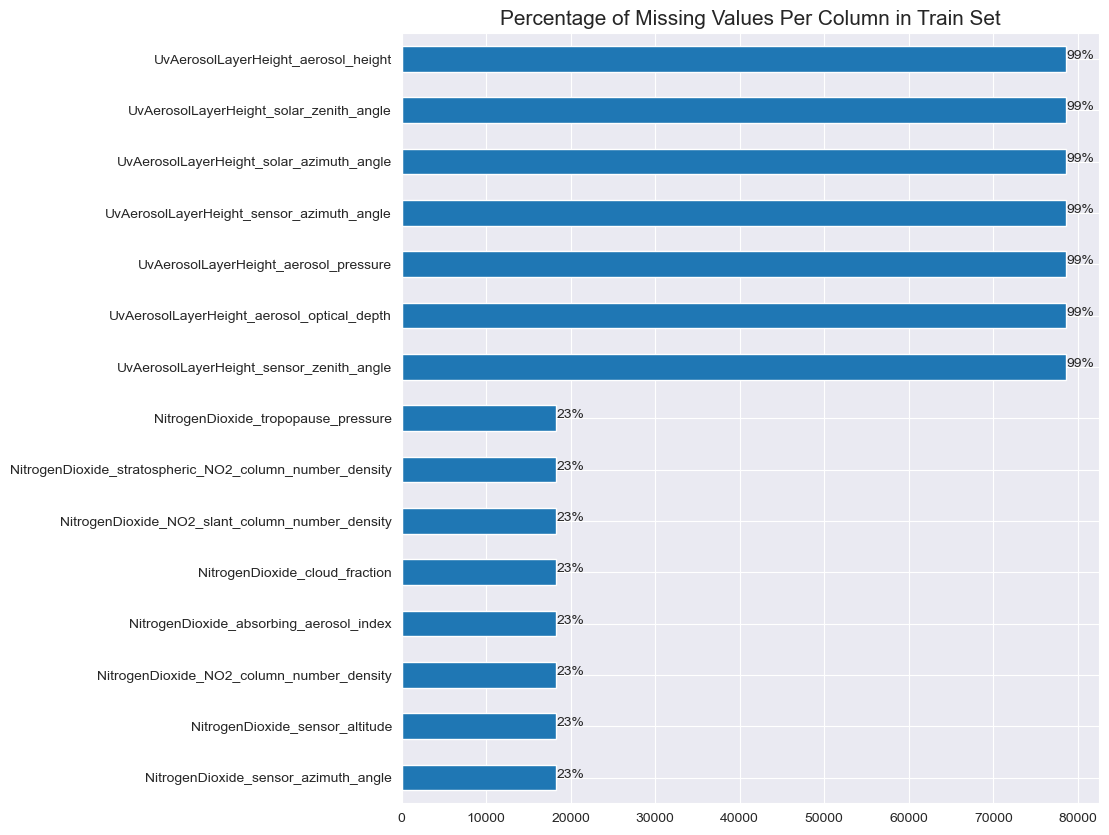

In [25]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False) [:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage = '{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width , height = p.get_width(), p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [26]:
#Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

In [27]:
#Data features EDA

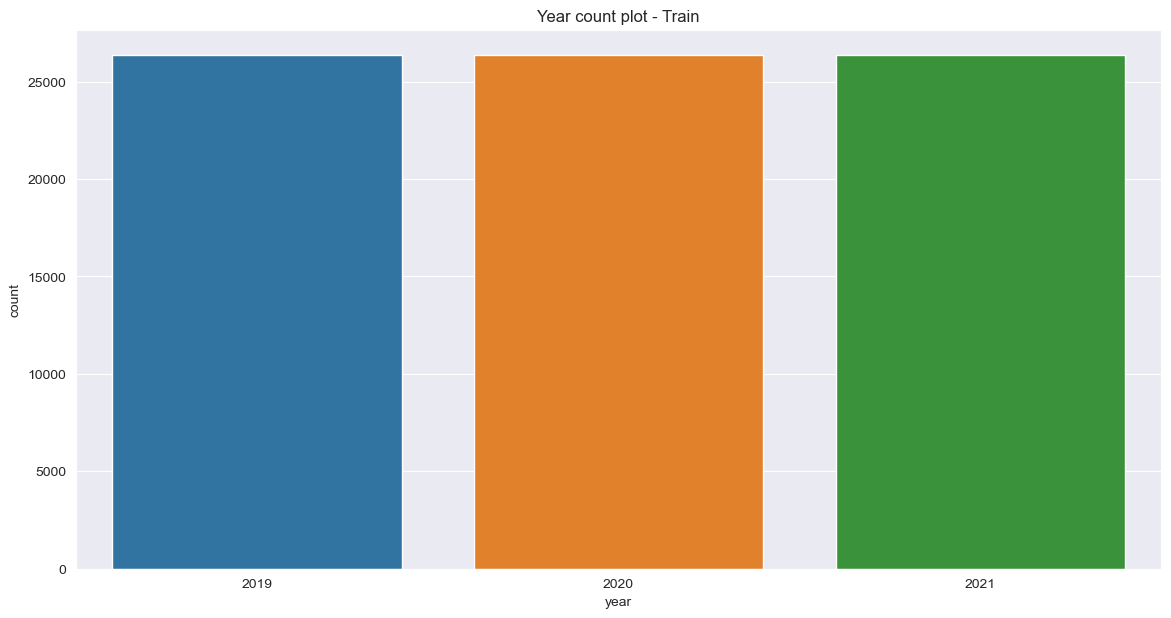

In [28]:
#Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train) #注意'year'是train其中一欄的名子，這個不能改
plt.title('Year count plot - Train')
plt.show()

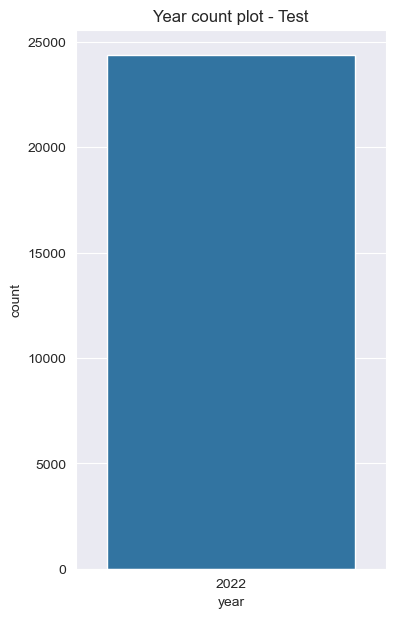

In [29]:
# Year countplot
plt.figure(figsize = (4, 7))
sns.countplot(x = 'year', data = test)
plt.title('Year count plot - Test')
plt.show()

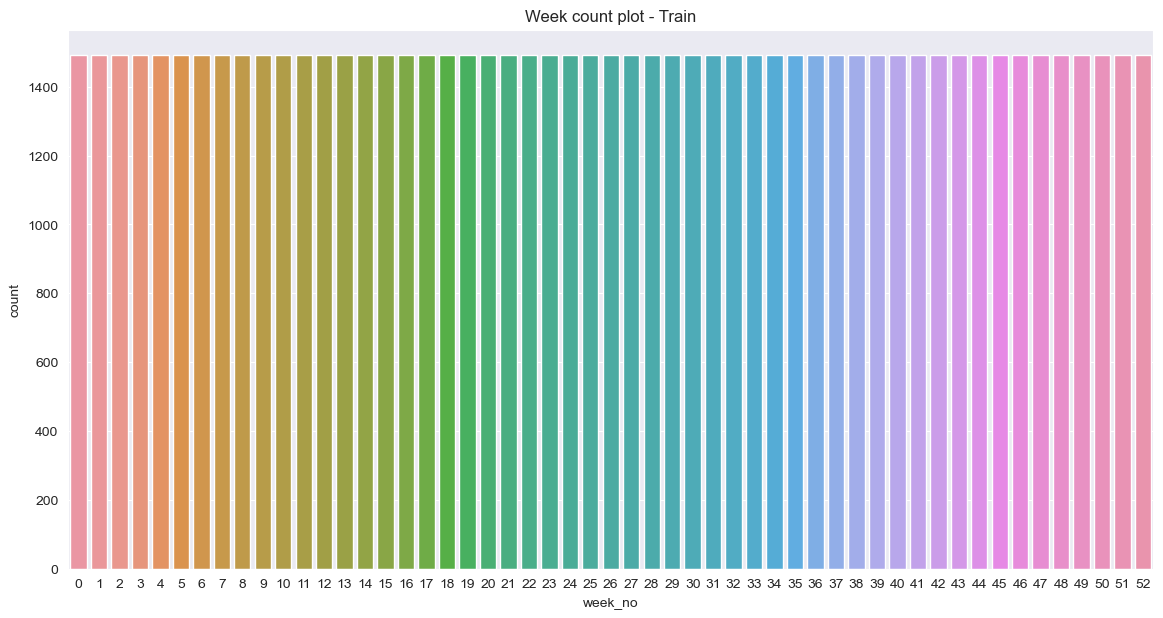

'\nThe number of observations of CO2 emissions are relatively the same across the weeks\n'

In [30]:
# Weak countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train) #week_no是train其中一欄
plt.title('Week count plot - Train')
plt.show()
"""
The number of observations of CO2 emissions are relatively the same across the weeks
"""

In [31]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

week_no
year         
2019       53
2020       53
2021       53

In [32]:
#Correlations - EDA

In [33]:
"""
這一段程式碼非常重要，因為它顯示出前20個跟emission最相關的幾個特徵。
"""
#Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                        1.0
longitude                                                   0.10275
UvAerosolLayerHeight_aerosol_height                        0.069008
UvAerosolLayerHeight_aerosol_pressure                      0.068138
Cloud_surface_albedo                                       0.046587
CarbonMonoxide_H2O_column_number_density                   0.043217
CarbonMonoxide_CO_column_number_density                    0.041328
Formaldehyde_tropospheric_HCHO_column_number_density_amf   0.040263
UvAerosolLayerHeight_aerosol_optical_depth                 0.040156
UvAerosolLayerHeight_sensor_azimuth_angle                  0.035142
NitrogenDioxide_solar_azimuth_angle                        0.033417
Formaldehyde_tropospheric_HCHO_column_number_density       0.033333
SulphurDioxide_solar_azimuth_angle                         0.032338
Formaldehyde_solar_azimuth_angle                           0.030815
NitrogenDioxide_sensor_altitude                 

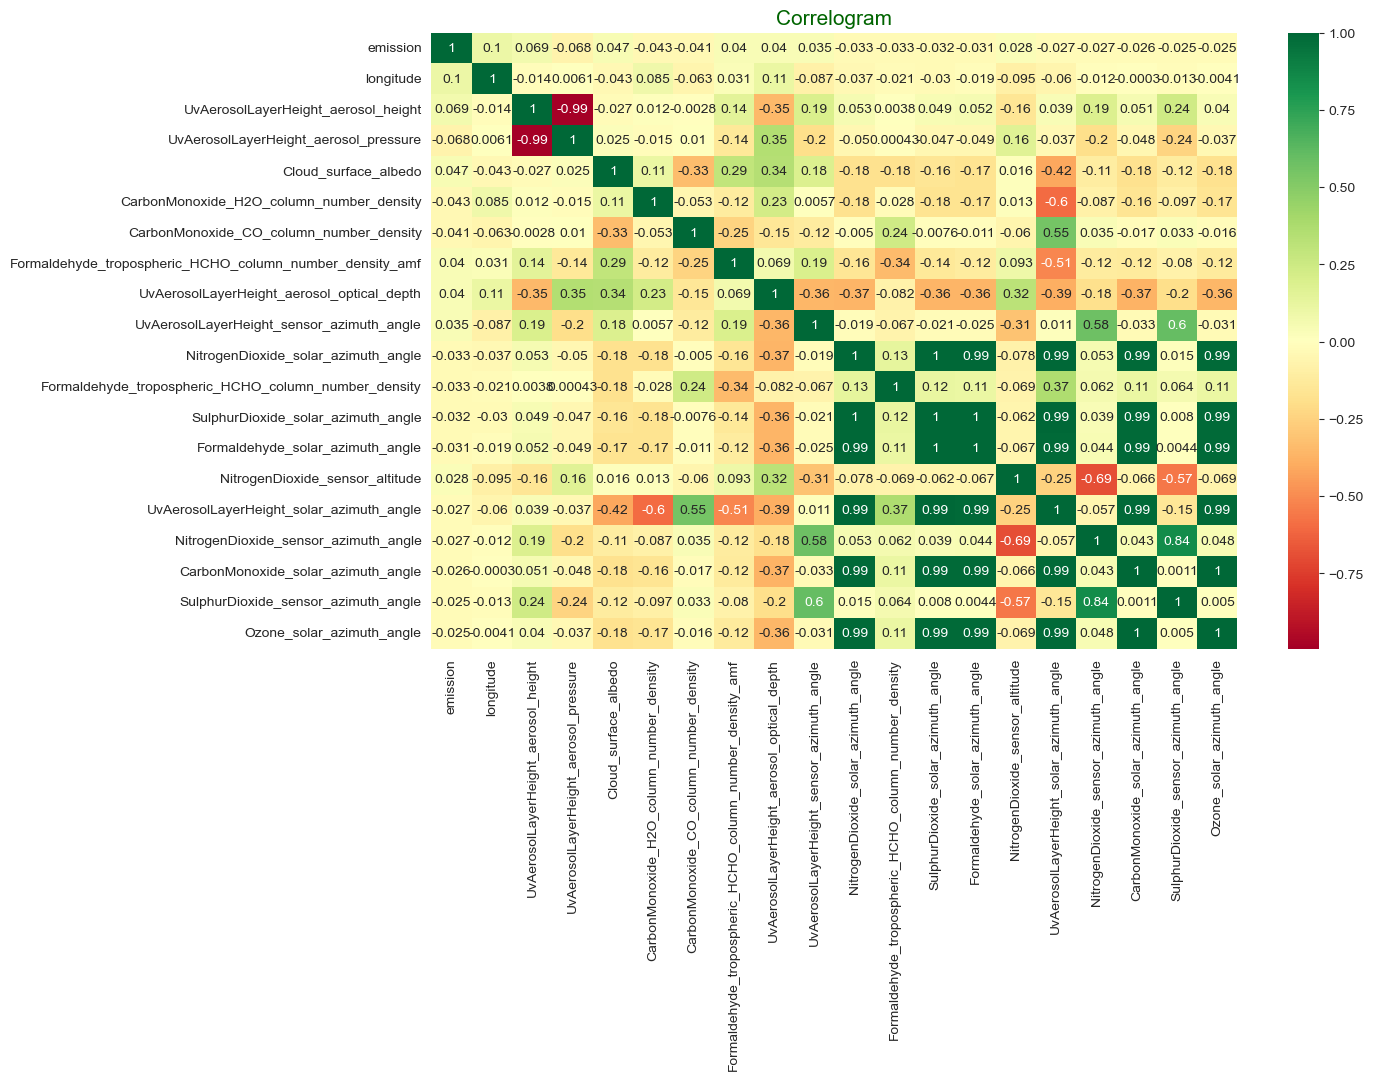

In [34]:
#Quantify correlations between features
corr = train[list(top20_corrs.index)].corr() #把剛剛的前20個轉成list，再當作train的index印出來
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap = 'RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen') #'darkgreen'就是設定相關係數為1時應該是什麼顏色。
plt.show()

In [35]:
#Timeseries visualization - EDA
"""
令人最興奮的地方!!
"""

'\n令人最興奮的地方!!\n'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


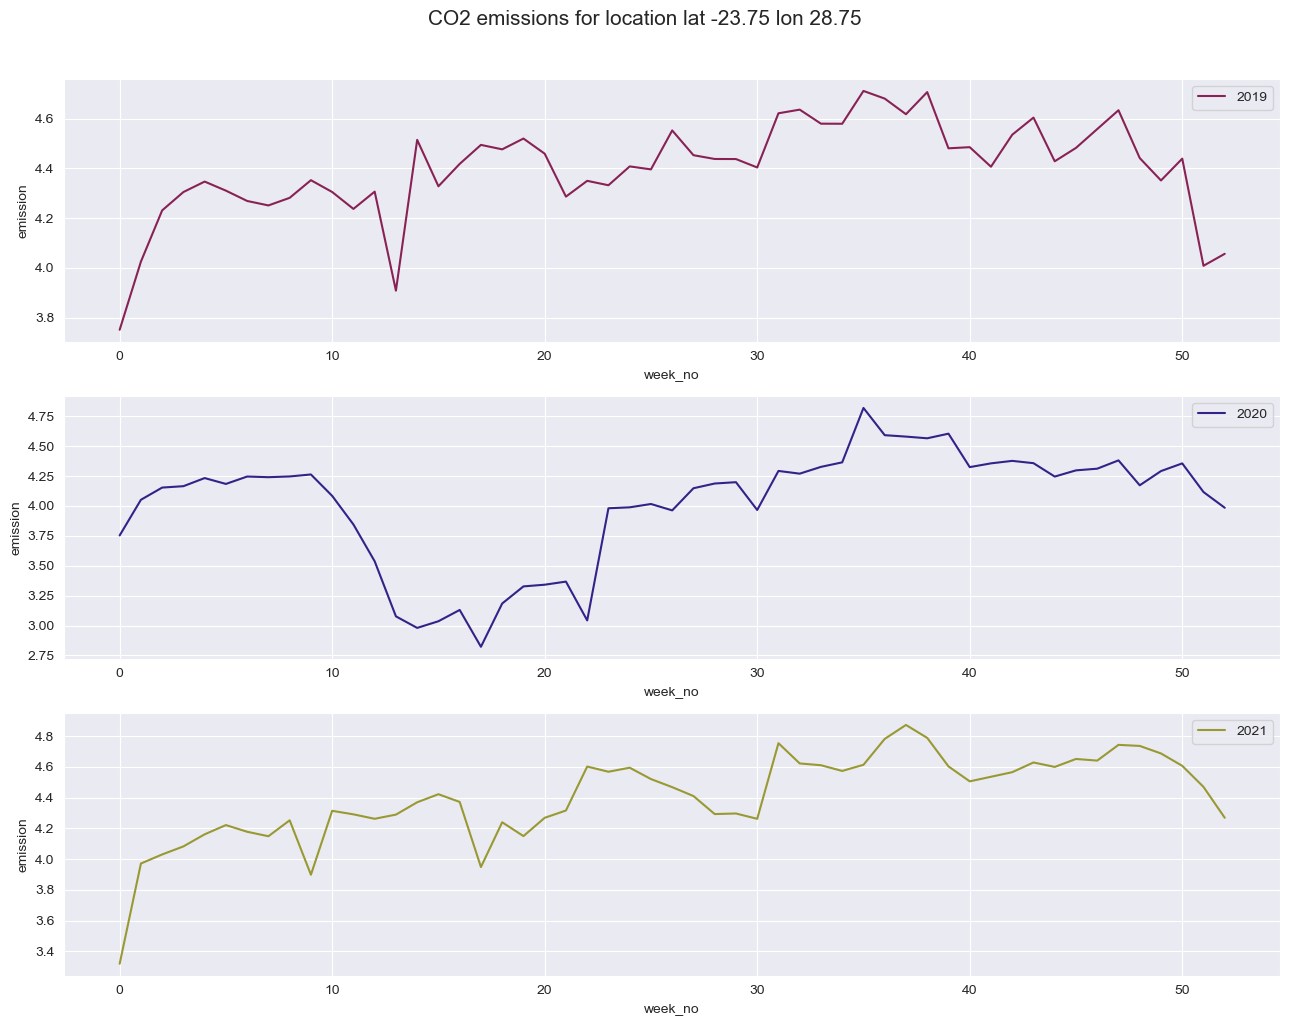

In [36]:
#Sample a unique location and visualize its emissions across the years
train.latitude, train.longtitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -0.510) & (train.longitude == 29.290)] #這是train前5筆資造裡面看到的一個地點

#Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (13, 10))
fig.suptitle('CO2 emissions for location lat -23.75 lon 28.75', y= 1.02, fontsize = 15)

#注意這裡zip是一一對應，像拉鍊一樣
for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288','#999933','orangered']):
    df = sample_loc[sample_loc.year == year]
    sns.lineplot(x=df.week_no, y=df.emission, ax = ax, label = year, color = color)
    plt.legend()
    plt.tight_layout()

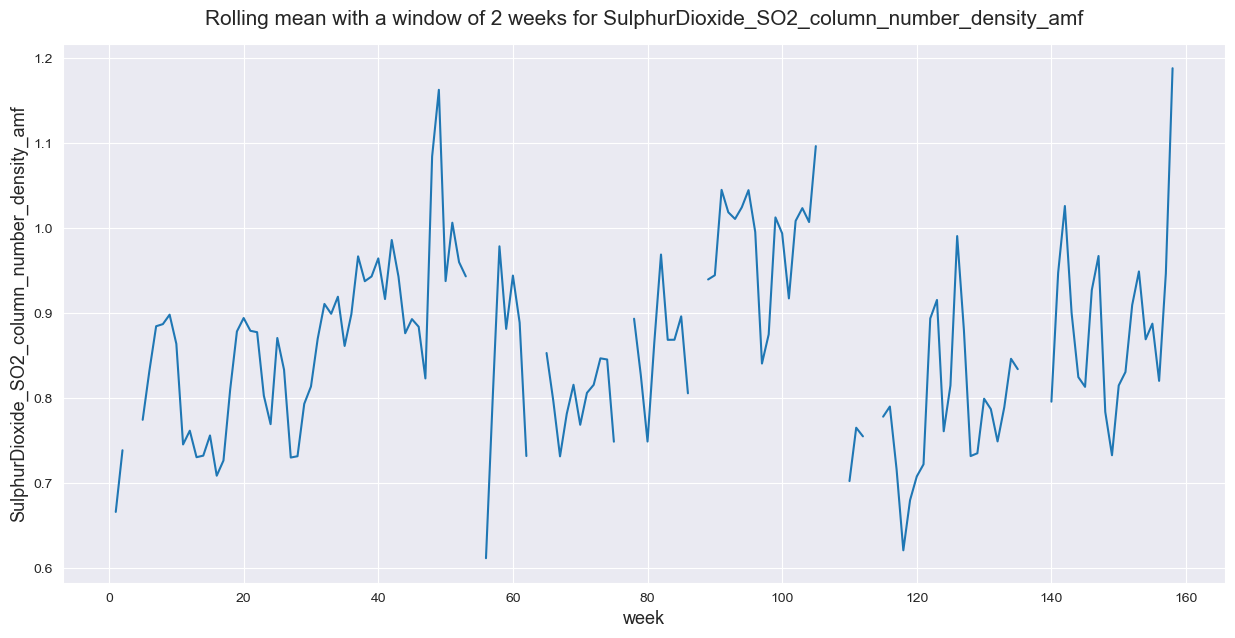

In [37]:
"""
注意，我們從EDA開始，畫出CO2的emission一直都只有單一地點而已，但我們實際上需要多個地點。
"""
#特徵工程的例子 : Aggregations, cumulative differences, moving averages ...
# 讓我們探索滾動平均值
#首先創造一個unique的經緯度，就是train再額外加一個欄叫做'location'.
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

#基於地點的filter，也就是說我要找特定地點的observation作為example
example_loc = train[train.location == '-0.51_29.29'] 
#我只取'-0.51_29.29'
#我有點擔心我們將經緯度只留下小數點後兩位的做法會讓我們在查詢的時候漏掉一些點

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
"""重要程式碼: 計算rolling mean的方法!!!"""
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualing rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y =1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

In [38]:
"""
With more research and domain knowledge generate useful features that can improve your model performance

Other examples of feature engineering:

1. Creating cluster regions
2. Interactions between different pollutatnts - ratios, additions,subtractions...
3. Time series features
"""

'\nWith more research and domain knowledge generate useful features that can improve your model performance\n\nOther examples of feature engineering:\n\n1. Creating cluster regions\n2. Interactions between different pollutatnts - ratios, additions,subtractions...\n3. Time series features\n'

In [39]:
"""
這裡最難懂!!!
"""
# Generate the above feature - rolling mean for all locations for both the train and test

#Feature engineering train
"""這一列不懂"""
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
               
"""這一列不懂"""
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
#下面這一列程式碼增加各種氣體在特定week_no滾動平均的欄位:
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns] 

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
"""這一列不懂"""
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
"""這一列不懂"""
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
#下面這一列程式碼增加各種氣體在特定week_no滾動平均的欄位:
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

SulphurDioxide_SO2_column_number_density_roll_mean  \
0                                                NaN    
1                                                NaN    
2                                         0.00030824    
3                                         0.00025527    
4                                         1.6513e-05    

   SulphurDioxide_SO2_column_number_density_amf_roll_mean  \
0                                                NaN        
1                                                NaN        
2                                            0.64814        
3                                            0.65101        
4                                            0.63872        

   SulphurDioxide_SO2_slant_column_number_density_roll_mean  \
0                                                NaN          
1                                                NaN          
2                                          0.0002107          
3                                         0.00017447          
4                                         2.9555e-05          

   SulphurDioxide_cloud_fraction_roll_mean  \
0                                      NaN   
1                                      NaN   
2                                 0.039935   
3                                  0.14045   
4                                  0.20269   

   SulphurDioxide_sensor_azimuth_angle_roll_mean  \
0                                            NaN   
1                                            NaN   
2                                         17.092   
3                                         15.057   
4                                          74.18   

   SulphurDioxide_sensor_zenith_angle_roll_mean  \
0                                           NaN   
1                                           NaN   
2                                        27.745   
3                                        49.376   
4                                        37.254   

   SulphurDioxide_solar_azimuth_angle_roll_mean  \
0                                           NaN   
1                                           NaN   
2                                       -138.72   
3                                       -144.95   
4                                        -144.4   

   SulphurDioxide_solar_zenith_angle_roll_mean  \
0                                          NaN   
1                                          NaN   
2                                       29.475   
3                                       25.931   
4                                       23.067   

   SulphurDioxide_SO2_column_number_density_15km_roll_mean  \
0                                                NaN         
1                                                NaN         
2                                         0.00010515         
3                                         7.3221e-05         
4                                           8.15e-06         

   CarbonMonoxide_CO_column_number_density_roll_mean  ...  \
0                                                NaN  ...   
1                                                NaN  ...   
2                                           0.037718  ...   
3                                           0.038769  ...   
4                                           0.039488  ...   

   Cloud_cloud_top_pressure_roll_mean  Cloud_cloud_top_height_roll_mean  \
0                                 NaN                               NaN   
1                          4.2281e+04                            7474.2   
2                          4.1336e+04                            7730.5   
3                          4.2494e+04                            7499.8   
4                          4.8725e+04                            6432.0   

   Cloud_cloud_base_pressure_roll_mean  Cloud_cloud_base_height_roll_mean  \
0                                  NaN                                NaN   
1                           4.7982e+04                          

In [40]:
# Merge engineered features with train and test set
"""為什麼會增加欄的數量近兩倍??? 因為每一個氣體排放量旁邊都加了該時間點的一個滾動平均數"""
#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)
# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)
# Preview engineered test set
test_eng.head()

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-0.510_29.290_2022_00     -0.51      29.29  2022        0   
1  ID_-0.510_29.290_2022_01     -0.51      29.29  2022        1   
2  ID_-0.510_29.290_2022_02     -0.51      29.29  2022        2   
3  ID_-0.510_29.290_2022_03     -0.51      29.29  2022        3   
4  ID_-0.510_29.290_2022_04     -0.51      29.29  2022        4   

   SulphurDioxide_SO2_column_number_density  \
0                                       NaN   
1                                0.00045592   
2                                0.00016056   
3                                0.00034998   
4                               -0.00031696   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                           NaN   
1                                       0.69116   
2                                       0.60511   
3                                       0.69692   
4                                       0.58053   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                             NaN   
1                                      0.00031558   
2                                      0.00010582   
3                                      0.00024311   
4                                       -0.000184   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                            NaN                                  NaN  ...   
1                            0.0                               76.239  ...   
2                        0.07987                              -42.055  ...   
3                        0.20103                                72.17  ...   
4                        0.20435                               76.191  ...   

   Cloud_cloud_top_pressure_roll_mean  Cloud_cloud_top_height_roll_mean  \
0                                 NaN                               NaN   
1                          4.2281e+04                            7474.2   
2                          4.1336e+04                            7730.5   
3                          4.2494e+04                            7499.8   
4                          4.8725e+04                            6432.0   

   Cloud_cloud_base_pressure_roll_mean  Cloud_cloud_base_height_roll_mean  \
0                                  NaN                                NaN   
1                           4.7982e+04                             6474.2   
2                           4.6961e+04                             6730.5   
3                           4.8326e+04                             6499.8   
4                           5.5271e+04                             5432.0   

   Cloud_cloud_optical_depth_roll_mean  Cloud_surface_albedo_roll_mean  \
0                                  NaN                             NaN   
1                                9.692                         0.26695   
2                               11.101                         0.28012   
3                               11.259                          0.2859   
4                               12.415                         0.29445   

   Cloud_sensor_azimuth_angle_roll_mean  Cloud_sensor_zenith_angle_roll_mean  \
0                                   NaN                                  NaN   
1                               -65.312                                38.05   
2                                4.2885                                44.17   
3                                7.3111                               44.038   
4                               -18.686                               36.132   

   Cloud_solar_azimuth_angle_roll_mean  Cloud_solar_zenith_angle_roll_mean  
0                                  NaN                                 NaN  
1                              -135.84                              32.396  
2                              -141.71                              28.878  
3                              -139.91                              28.174  
4

In [41]:
train_eng.head(1000) #有'emission'這一個名稱的欄位

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0    ID_-0.510_29.290_2019_00     -0.51      29.29  2019        0   
1    ID_-0.510_29.290_2019_01     -0.51      29.29  2019        1   
2    ID_-0.510_29.290_2019_02     -0.51      29.29  2019        2   
3    ID_-0.510_29.290_2019_03     -0.51      29.29  2019        3   
4    ID_-0.510_29.290_2019_04     -0.51      29.29  2019        4   
5    ID_-0.510_29.290_2019_05     -0.51      29.29  2019        5   
6    ID_-0.510_29.290_2019_06     -0.51      29.29  2019        6   
7    ID_-0.510_29.290_2019_07     -0.51      29.29  2019        7   
8    ID_-0.510_29.290_2019_08     -0.51      29.29  2019        8   
9    ID_-0.510_29.290_2019_09     -0.51      29.29  2019        9   
10   ID_-0.510_29.290_2019_10     -0.51      29.29  2019       10   
11   ID_-0.510_29.290_2019_11     -0.51      29.29  2019       11   
12   ID_-0.510_29.290_2019_12     -0.51      29.29  2019       12   
13   ID_-0.510_29.290_2019_13     -0.51      29.29  2019       13   
14   ID_-0.510_29.290_2019_14     -0.51      29.29  2019       14   
15   ID_-0.510_29.290_2019_15     -0.51      29.29  2019       15   
16   ID_-0.510_29.290_2019_16     -0.51      29.29  2019       16   
17   ID_-0.510_29.290_2019_17     -0.51      29.29  2019       17   
18   ID_-0.510_29.290_2019_18     -0.51      29.29  2019       18   
19   ID_-0.510_29.290_2019_19     -0.51      29.29  2019       19   
20   ID_-0.510_29.290_2019_20     -0.51      29.29  2019       20   
21   ID_-0.510_29.290_2019_21     -0.51      29.29  2019       21   
22   ID_-0.510_29.290_2019_22     -0.51      29.29  2019       22   
23   ID_-0.510_29.290_2019_23     -0.51      29.29  2019       23   
24   ID_-0.510_29.290_2019_24     -0.51      29.29  2019       24   
25   ID_-0.510_29.290_2019_25     -0.51      29.29  2019       25   
26   ID_-0.510_29.290_2019_26     -0.51      29.29  2019       26   
27   ID_-0.510_29.290_2019_27     -0.51      29.29  2019       27   
28   ID_-0.510_29.290_2019_28     -0.51      29.29  2019       28   
29   ID_-0.510_29.290_2019_29     -0.51      29.29  2019       29   
30   ID_-0.510_29.290_2019_30     -0.51      29.29  2019       30   
31   ID_-0.510_29.290_2019_31     -0.51      29.29  2019       31   
32   ID_-0.510_29.290_2019_32     -0.51      29.29  2019       32   
33   ID_-0.510_29.290_2019_33     -0.51      29.29  2019       33   
34   ID_-0.510_29.290_2019_34     -0.51      29.29  2019       34   
35   ID_-0.510_29.290_2019_35     -0.51      29.29  2019       35   
36   ID_-0.510_29.290_2019_36     -0.51      29.29  2019       36   
37   ID_-0.510_29.290_2019_37     -0.51      29.29  2019       37   
38   ID_-0.510_29.290_2019_38     -0.51      29.29  2019       38   
39   ID_-0.510_29.290_2019_39     -0.51      29.29  2019       39   
40   ID_-0.510_29.290_2019_40     -0.51      29.29  2019       40   
41   ID_-0.510_29.290_2019_41     -0.51      29.29  2019       41   
42   ID_-0.510_29.290_2019_42     -0.51      29.29  2019       42   
43   ID_-0.510_29.290_2019_43     -0.51      29.29  2019       43   
44   ID_-0.510_29.290_2019_44     -0.51      29.29  2019       44   
45   ID_-0.510_29.290_2019_45     -0.51      29.29  2019       45   
46   ID_-0.510_29.290_2019_46     -0.51      29.29  2019       46   
47   ID_-0.510_29.290_2019_47     -0.51      29.29  2019       47   
48   ID_-0.510_29.290_2019_48     -0.51      29.29  2019       48   
49   ID_-0.510_29.290_2019_49     -0.51      29.29  2019       49   
50   ID_-0.510_29.290_2019_50     -0.51      29.29  2019       50   
51   ID_-0.510_29.290_2019_51     -0.51      29.29  2019       51   
52   ID_-0.510_29.290_2019_52     -0.51      29.29  2019       52   
53   ID_-0.510_29.290_2020_00     -0.51      29.29  2020        0   
54   ID_-0.510_29.290_2020_01     -0.51      29.29  2020        1   
55   ID_-0.510_29.290_2020_02     -0.51      29.29  2020        2   
56   ID_-0.510_29.290_2020_03     -0.51      29.29  2020        3   
57   ID

In [42]:
test_eng.head() #注意它比起Train_eng少了一欄，因為沒有"emission".

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-0.510_29.290_2022_00     -0.51      29.29  2022        0   
1  ID_-0.510_29.290_2022_01     -0.51      29.29  2022        1   
2  ID_-0.510_29.290_2022_02     -0.51      29.29  2022        2   
3  ID_-0.510_29.290_2022_03     -0.51      29.29  2022        3   
4  ID_-0.510_29.290_2022_04     -0.51      29.29  2022        4   

   SulphurDioxide_SO2_column_number_density  \
0                                       NaN   
1                                0.00045592   
2                                0.00016056   
3                                0.00034998   
4                               -0.00031696   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                           NaN   
1                                       0.69116   
2                                       0.60511   
3                                       0.69692   
4                                       0.58053   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                             NaN   
1                                      0.00031558   
2                                      0.00010582   
3                                      0.00024311   
4                                       -0.000184   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                            NaN                                  NaN  ...   
1                            0.0                               76.239  ...   
2                        0.07987                              -42.055  ...   
3                        0.20103                                72.17  ...   
4                        0.20435                               76.191  ...   

   Cloud_cloud_top_pressure_roll_mean  Cloud_cloud_top_height_roll_mean  \
0                                 NaN                               NaN   
1                          4.2281e+04                            7474.2   
2                          4.1336e+04                            7730.5   
3                          4.2494e+04                            7499.8   
4                          4.8725e+04                            6432.0   

   Cloud_cloud_base_pressure_roll_mean  Cloud_cloud_base_height_roll_mean  \
0                                  NaN                                NaN   
1                           4.7982e+04                             6474.2   
2                           4.6961e+04                             6730.5   
3                           4.8326e+04                             6499.8   
4                           5.5271e+04                             5432.0   

   Cloud_cloud_optical_depth_roll_mean  Cloud_surface_albedo_roll_mean  \
0                                  NaN                             NaN   
1                                9.692                         0.26695   
2                               11.101                         0.28012   
3                               11.259                          0.2859   
4                               12.415                         0.29445   

   Cloud_sensor_azimuth_angle_roll_mean  Cloud_sensor_zenith_angle_roll_mean  \
0                                   NaN                                  NaN   
1                               -65.312                                38.05   
2                                4.2885                                44.17   
3                                7.3111                               44.038   
4                               -18.686                               36.132   

   Cloud_solar_azimuth_angle_roll_mean  Cloud_solar_zenith_angle_roll_mean  
0                                  NaN                                 NaN  
1                              -135.84                              32.396  
2                              -141.71                              28.878  
3                              -139.91                              28.174  
4

In [43]:
train_eng["latitude"].value_counts()
train_eng["longitude"].value_counts()

29.601    636
30.029    477
30.245    477
30.647    318
29.168    318
29.33     318
30.734    318
29.5      318
29.898    318
28.811    318
28.467    318
30.971    318
28.977    318
29.926    318
30.603    318
29.145    318
28.547    318
30.19     318
30.364    318
29.218    318
29.617    318
29.722    318
29.404    318
29.995    318
30.285    318
30.932    318
29.883    318
29.178    318
30.763    318
30.341    318
28.872    318
30.281    318
30.471    318
28.461    318
30.138    318
28.724    318
30.621    318
30.03     318
29.798    318
28.753    318
30.515    159
30.917    159
30.765    159
28.652    159
30.223    159
28.404    159
29.506    159
30.446    159
29.62     159
28.645    159
29.29     159
29.018    159
28.744    159
29.787    159
30.638    159
30.847    159
29.665    159
29.458    159
29.059    159
30.071    159
29.57     159
28.671    159
31.181    159
28.883    159
29.489    159
30.243    159
30.996    159
29.609    159
29.507    159
29.92     159
30.231    159
29.933

In [44]:
train_eng["emission"].isnull().sum() #全部都有values

0

In [45]:
#特定經緯度的CO2 emission
train_eng.loc[(train_eng.latitude == -0.51) & (train_eng.longitude == 29.29)]["emission"].shape


(159,)

In [46]:
train_eng.loc[(train_eng.latitude == -0.51) & (train_eng.longitude == 29.29)]["week_no"]
"""
他的week_no一年有重複一次，絕對不能直接用!!要先轉成三年的總week數
"""

'\n他的week_no一年有重複一次，絕對不能直接用!!要先轉成三年的總week數\n'

In [47]:
week_total = train_eng.loc[(train_eng.latitude == -0.51) & (train_eng.longitude == 29.29)]["week_no"].shape[0]
total_week_no = pd.Series(range(week_total))
print(total_week_no.shape)
display(total_week_no)

(159,)


0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
12      12
13      13
14      14
15      15
16      16
17      17
18      18
19      19
20      20
21      21
22      22
23      23
24      24
25      25
26      26
27      27
28      28
29      29
30      30
31      31
32      32
33      33
34      34
35      35
36      36
37      37
38      38
39      39
40      40
41      41
42      42
43      43
44      44
45      45
46      46
47      47
48      48
49      49
50      50
51      51
52      52
53      53
54      54
55      55
56      56
57      57
58      58
59      59
60      60
61      61
62      62
63      63
64      64
65      65
66      66
67      67
68      68
69      69
70      70
71      71
72      72
73      73
74      74
75      75
76      76
77      77
78      78
79      79
80      80
81      81
82      82
83      83
84      84
85      85
86      86
87      87
88      88
89      89
90      90

In [48]:
"""上面幾行的特徵工程主要是做滾動平均還有"""

'上面幾行的特徵工程主要是做滾動平均還有'

In [49]:
"""
這裡用randomforest
"""

"""
#選出"互相獨立"的特徵和target variable(i.e. emission)
#下面將NA值替換成0
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

#Instantiating the model
#n_jobs: 這是用於訓練模型的並行工作數。設置為-1表示使用所有可用的CPU核心來並行處理，這有助於加速模型的訓練過程。

clf = RandomForestRegressor(random_state = SEED, n_jobs = -1)
clf.fit(X_train, y_train)

#Making predictions
y_pred = clf.predict(X_test) #這是要給我們看proformance用的

#Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared = False)}' )
"""

'\n#選出"互相獨立"的特徵和target variable(i.e. emission)\n#下面將NA值替換成0\nX = train_eng.drop([\'ID_LAT_LON_YEAR_WEEK\', \'location\', \'emission\'], axis = 1).fillna(0)\ny = train_eng.emission\n\n#Splitting the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)\n\n#Instantiating the model\n#n_jobs: 這是用於訓練模型的並行工作數。設置為-1表示使用所有可用的CPU核心來並行處理，這有助於加速模型的訓練過程。\n\nclf = RandomForestRegressor(random_state = SEED, n_jobs = -1)\nclf.fit(X_train, y_train)\n\n#Making predictions\ny_pred = clf.predict(X_test) #這是要給我們看proformance用的\n\n#Measuring the accuracy of the model\nprint(f\'RMSE Score: {mean_squared_error(y_test, y_pred, squared = False)}\' )\n'

In [50]:
#X_test.head()

In [51]:
"""
To do list:
1. Imputation of CO2 emission data.
2. Moving average and preliminary prediction.
3. Use ML method to predict.
"""

'\nTo do list:\n1. Imputation of CO2 emission data.\n2. Moving average and preliminary prediction.\n3. Use ML method to predict.\n'

In [52]:
"""
如果你希望將其他氣體的排放納入模型中，有幾種方法可以考慮：

1. **Feature Engineering**: 在建立模型之前，你可以進行特徵工程，從其他氣體排放數據中創建新的特徵，這些特徵可能與二氧化碳排放有關。例如，你可以計算不同氣體排放之間的相對比例，或者創建時間特徵，如每年的氣體排放增長率。

2. **Multivariate Time Series Model**: 如果你的數據是多變量時間序列數據，你可以考慮使用支持多變量的時間序列模型。一個常見的選擇是Vector Autoregression (VAR) 模型，它允許你在同一模型中處理多個相關時間序列。這樣的模型可以捕捉不同氣體排放之間的相互作用。

3. **Deep Learning Models**: 你也可以考慮使用深度學習模型，如長短期記憶網絡（LSTM）或卷積神經網絡（CNN）。這些模型能夠處理多變量時間序列數據，並且可以學習不同氣體排放之間的複雜關係。

4. **Ensemble Methods**: 如果你的模型預測主要是基於二氧化碳的排放，但你仍然希望利用其他氣體的信息，可以考慮使用集成方法。例如，你可以將單變量的二氧化碳預測與多變量的其他氣體預測進行結合，以得到綜合的預測結果。

請注意，選擇哪種方法取決於你的數據特性、預測目標和預測準確性需求。你可以根據對數據的理解和模型驗證結果來選擇最適合的方法。
"""

'\n如果你希望將其他氣體的排放納入模型中，有幾種方法可以考慮：\n\n1. **Feature Engineering**: 在建立模型之前，你可以進行特徵工程，從其他氣體排放數據中創建新的特徵，這些特徵可能與二氧化碳排放有關。例如，你可以計算不同氣體排放之間的相對比例，或者創建時間特徵，如每年的氣體排放增長率。\n\n2. **Multivariate Time Series Model**: 如果你的數據是多變量時間序列數據，你可以考慮使用支持多變量的時間序列模型。一個常見的選擇是Vector Autoregression (VAR) 模型，它允許你在同一模型中處理多個相關時間序列。這樣的模型可以捕捉不同氣體排放之間的相互作用。\n\n3. **Deep Learning Models**: 你也可以考慮使用深度學習模型，如長短期記憶網絡（LSTM）或卷積神經網絡（CNN）。這些模型能夠處理多變量時間序列數據，並且可以學習不同氣體排放之間的複雜關係。\n\n4. **Ensemble Methods**: 如果你的模型預測主要是基於二氧化碳的排放，但你仍然希望利用其他氣體的信息，可以考慮使用集成方法。例如，你可以將單變量的二氧化碳預測與多變量的其他氣體預測進行結合，以得到綜合的預測結果。\n\n請注意，選擇哪種方法取決於你的數據特性、預測目標和預測準確性需求。你可以根據對數據的理解和模型驗證結果來選擇最適合的方法。\n'

In [53]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [54]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [55]:
"""重要"""
"""這裡要改!!!!!!"""
time = total_week_no #這幾年的累積禮拜數(不會在年初從頭算)
series = train_eng.loc[(train_eng.latitude == -0.51) & (train_eng.longitude == 29.29)]["emission"] #特定經緯度的CO2 emission

# Define the split time
split_time = 104

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [56]:
print("time.shape = ",time.shape)
print("series.shape = ",series.shape)

time.shape =  (159,)
series.shape =  (159,)


In [57]:
time.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [111]:
# Parameters
window_size = 4
batch_size = 3 #32
shuffle_buffer_size = 100

In [112]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    #dataset = dataset.batch(batch_size).prefetch(1)
    dataset = dataset.prefetch(1)
    return dataset

In [113]:
"""這裡要加入經緯度資料"""
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [1]:
#製作把經緯度考慮進去的dataset

coordinates = zip(train_eng["latitude"],train_eng["longitude"])
coordinates = list(coordinates)
coordinates = set(coordinates)
coordinates = list(coordinates)
"""
這裡先只取一個
"""
lat_and_long = coordinates[1]

week_total = train_eng.loc[(train_eng.latitude == lat_and_long[0]) & (train_eng.longitude == lat_and_long[1])]["week_no"].shape[0]
total_week_no = pd.Series(range(week_total))
print(week_total)
time = total_week_no #這幾年的累積禮拜數(不會在年初從頭算)
series = train_eng.loc[(train_eng.latitude == lat_and_long[0]) & (train_eng.longitude == lat_and_long[1])]["emission"] #特定經緯度的CO2 emission

# Define the split time
split_time = 104

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Generate the dataset windows
dataset_ = windowed_dataset(x_train, window_size, batch_size = 9999 , shuffle_buffer = shuffle_buffer_size)

tensor_list_1 = []
tensor_list_2 = []

for batch_features, batch_labels in dataset_: 
    #concat datas one by one
    coor_reshape = tf.reshape( tf.convert_to_tensor(lat_and_long), [2])#coor_reshape = tf.reshape( tf.convert_to_tensor(lat_and_long), [1,2])

    batch_feature = tf.cast(batch_features, tf.float32)#[np.newaxis]
    coor_reshape_repeat = coor_reshape #tf.repeat(coor_reshape, repeats = [batch_feature.shape[0]], axis=0)  

    print(batch_feature.shape)
    print(coor_reshape_repeat.shape)
    concat = tf.concat([batch_feature, coor_reshape_repeat], axis =0) #axis = 1
    print("concat =",concat)
    batch_label = tf.cast(batch_labels, tf.float32)

    #Append a single batch into lists 
    print("list 1 append concat =",concat)
    tensor_list_1.append(concat)
    tensor_list_2.append(batch_label)

# Convert the lists to tensors
tensor_list_1 = [tf.convert_to_tensor(tensor) for tensor in tensor_list_1]
tensor_list_2 = [tf.convert_to_tensor(tensor) for tensor in tensor_list_2]
#print("len of list", len(tensor_list_1))

# Create a new dataset using from_tensor_slices
new_dataset = tf.data.Dataset.from_tensor_slices((tensor_list_1, tensor_list_2)).batch(batch_size).prefetch(1)

# Print the elements of the new dataset
for item in new_dataset:
    print(type(item))
    print(len(item))
    print("item[0] = ",item[0].shape)
    print("item[1] = ",item[1].shape)

for item in tensor_list_1:
    print(item)

NameError: name 'train_eng' is not defined

In [124]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size + 2]),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    #tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                70        
                                                                 
 activation_3 (Activation)   (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 20)                220       
                                                                 
 dense_14 (Dense)            (None, 80)                1680      
                                                                 
 dense_15 (Dense)            (None, 1)                 81        
                                                                 
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________


In [125]:
#原本的程式碼
# Build the model

"""
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size + 2], activation="relu"),#tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    #tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()
"""

'\nmodel_baseline = tf.keras.models.Sequential([\n    tf.keras.layers.Dense(10, input_shape=[window_size + 2], activation="relu"),#tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),\n    tf.keras.layers.Dense(20, activation="relu"),\n    tf.keras.layers.Dense(80, activation="relu"),\n    #tf.keras.layers.Dense(10, activation="relu"),\n    tf.keras.layers.Dense(1)\n])\n\n# Print the model summary\nmodel_baseline.summary()\n'

In [126]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
#model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [127]:
# Train the model
model_baseline.fit(new_dataset,epochs=3000) #model_baseline.fit(new_dataset,epochs=1500)

Epoch 1/3000
34/34 [==============================] - 1s 3ms/step - loss: 8771.6924
Epoch 2/3000
34/34 [==============================] - 0s 2ms/step - loss: 8522.4551
Epoch 3/3000
34/34 [==============================] - 0s 2ms/step - loss: 8274.4102
Epoch 4/3000
34/34 [==============================] - 0s 2ms/step - loss: 8029.7944
Epoch 5/3000
34/34 [==============================] - 0s 2ms/step - loss: 7789.0327
Epoch 6/3000
34/34 [==============================] - 0s 2ms/step - loss: 7552.4624
Epoch 7/3000
34/34 [==============================] - 0s 2ms/step - loss: 7320.2974
Epoch 8/3000
34/34 [==============================] - 0s 2ms/step - loss: 7092.7227
Epoch 9/3000
34/34 [==============================] - 0s 2ms/step - loss: 6869.5176
Epoch 10/3000
34/34 [==============================] - 0s 2ms/step - loss: 6650.8213
Epoch 11/3000
34/34 [==============================] - 0s 2ms/step - loss: 6436.5273
Epoch 12/3000
34/34 [==============================] - 0s 2ms/step - loss:

Epoch 98/3000
34/34 [==============================] - 0s 3ms/step - loss: 452.8496
Epoch 99/3000
34/34 [==============================] - 0s 3ms/step - loss: 451.8326
Epoch 100/3000
34/34 [==============================] - 0s 3ms/step - loss: 450.8480
Epoch 101/3000
34/34 [==============================] - 0s 3ms/step - loss: 449.9032
Epoch 102/3000
34/34 [==============================] - 0s 2ms/step - loss: 448.9948
Epoch 103/3000
34/34 [==============================] - 0s 2ms/step - loss: 448.1235
Epoch 104/3000
34/34 [==============================] - 0s 2ms/step - loss: 447.3090
Epoch 105/3000
34/34 [==============================] - 0s 2ms/step - loss: 446.5204
Epoch 106/3000
34/34 [==============================] - 0s 2ms/step - loss: 445.7451
Epoch 107/3000
34/34 [==============================] - 0s 2ms/step - loss: 444.9857
Epoch 108/3000
34/34 [==============================] - 0s 2ms/step - loss: 444.2538
Epoch 109/3000
34/34 [==============================] - 0s 2ms/step

34/34 [==============================] - 0s 3ms/step - loss: 363.9684
Epoch 291/3000
34/34 [==============================] - 0s 3ms/step - loss: 363.6536
Epoch 292/3000
34/34 [==============================] - 0s 3ms/step - loss: 363.3517
Epoch 293/3000
34/34 [==============================] - 0s 3ms/step - loss: 363.0442
Epoch 294/3000
34/34 [==============================] - 0s 3ms/step - loss: 362.7349
Epoch 295/3000
34/34 [==============================] - 0s 3ms/step - loss: 362.4301
Epoch 296/3000
34/34 [==============================] - 0s 3ms/step - loss: 362.1281
Epoch 297/3000
34/34 [==============================] - 0s 3ms/step - loss: 361.8217
Epoch 298/3000
34/34 [==============================] - 0s 3ms/step - loss: 361.5203
Epoch 299/3000
34/34 [==============================] - 0s 3ms/step - loss: 361.2126
Epoch 300/3000
34/34 [==============================] - 0s 3ms/step - loss: 360.9176
Epoch 301/3000
34/34 [==============================] - 0s 2ms/step - loss: 360.

34/34 [==============================] - 0s 2ms/step - loss: 316.9806
Epoch 483/3000
34/34 [==============================] - 0s 2ms/step - loss: 316.7960
Epoch 484/3000
34/34 [==============================] - 0s 2ms/step - loss: 316.6112
Epoch 485/3000
34/34 [==============================] - 0s 2ms/step - loss: 316.4200
Epoch 486/3000
34/34 [==============================] - 0s 2ms/step - loss: 316.2349
Epoch 487/3000
34/34 [==============================] - 0s 2ms/step - loss: 316.0544
Epoch 488/3000
34/34 [==============================] - 0s 2ms/step - loss: 315.8651
Epoch 489/3000
34/34 [==============================] - 0s 2ms/step - loss: 315.6812
Epoch 490/3000
34/34 [==============================] - 0s 2ms/step - loss: 315.4997
Epoch 491/3000
34/34 [==============================] - 0s 2ms/step - loss: 315.3135
Epoch 492/3000
34/34 [==============================] - 0s 2ms/step - loss: 315.1326
Epoch 493/3000
34/34 [==============================] - 0s 2ms/step - loss: 314.

34/34 [==============================] - 0s 2ms/step - loss: 289.4128
Epoch 675/3000
34/34 [==============================] - 0s 2ms/step - loss: 289.3086
Epoch 676/3000
34/34 [==============================] - 0s 2ms/step - loss: 289.2000
Epoch 677/3000
34/34 [==============================] - 0s 2ms/step - loss: 289.0989
Epoch 678/3000
34/34 [==============================] - 0s 2ms/step - loss: 288.9990
Epoch 679/3000
34/34 [==============================] - 0s 2ms/step - loss: 288.8914
Epoch 680/3000
34/34 [==============================] - 0s 2ms/step - loss: 288.7955
Epoch 681/3000
34/34 [==============================] - 0s 2ms/step - loss: 288.6933
Epoch 682/3000
34/34 [==============================] - 0s 2ms/step - loss: 288.5875
Epoch 683/3000
34/34 [==============================] - 0s 2ms/step - loss: 288.4876
Epoch 684/3000
34/34 [==============================] - 0s 2ms/step - loss: 288.3813
Epoch 685/3000
34/34 [==============================] - 0s 2ms/step - loss: 288.

34/34 [==============================] - 0s 2ms/step - loss: 274.3486
Epoch 867/3000
34/34 [==============================] - 0s 2ms/step - loss: 274.2982
Epoch 868/3000
34/34 [==============================] - 0s 2ms/step - loss: 274.2313
Epoch 869/3000
34/34 [==============================] - 0s 3ms/step - loss: 274.1833
Epoch 870/3000
34/34 [==============================] - 0s 2ms/step - loss: 274.1257
Epoch 871/3000
34/34 [==============================] - 0s 3ms/step - loss: 274.0677
Epoch 872/3000
34/34 [==============================] - 0s 3ms/step - loss: 274.0200
Epoch 873/3000
34/34 [==============================] - 0s 3ms/step - loss: 273.9586
Epoch 874/3000
34/34 [==============================] - 0s 2ms/step - loss: 273.9021
Epoch 875/3000
34/34 [==============================] - 0s 2ms/step - loss: 273.8543
Epoch 876/3000
34/34 [==============================] - 0s 2ms/step - loss: 273.7962
Epoch 877/3000
34/34 [==============================] - 0s 2ms/step - loss: 273.

34/34 [==============================] - 0s 3ms/step - loss: 266.3238
Epoch 1058/3000
34/34 [==============================] - 0s 2ms/step - loss: 266.2899
Epoch 1059/3000
34/34 [==============================] - 0s 2ms/step - loss: 266.2589
Epoch 1060/3000
34/34 [==============================] - 0s 2ms/step - loss: 266.2354
Epoch 1061/3000
34/34 [==============================] - 0s 2ms/step - loss: 266.2011
Epoch 1062/3000
34/34 [==============================] - 0s 3ms/step - loss: 266.1693
Epoch 1063/3000
34/34 [==============================] - 0s 3ms/step - loss: 266.1412
Epoch 1064/3000
34/34 [==============================] - 0s 2ms/step - loss: 266.1071
Epoch 1065/3000
34/34 [==============================] - 0s 2ms/step - loss: 266.0782
Epoch 1066/3000
34/34 [==============================] - 0s 2ms/step - loss: 266.0484
Epoch 1067/3000
34/34 [==============================] - 0s 2ms/step - loss: 266.0185
Epoch 1068/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 261.6416
Epoch 1248/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.6236
Epoch 1249/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.5986
Epoch 1250/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.5819
Epoch 1251/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.5574
Epoch 1252/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.5370
Epoch 1253/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.5238
Epoch 1254/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.5022
Epoch 1255/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.4815
Epoch 1256/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.4594
Epoch 1257/3000
34/34 [==============================] - 0s 2ms/step - loss: 261.4412
Epoch 1258/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 258.3172
Epoch 1438/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.3047
Epoch 1439/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.2869
Epoch 1440/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.2716
Epoch 1441/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.2591
Epoch 1442/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.2424
Epoch 1443/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.2302
Epoch 1444/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.2156
Epoch 1445/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.2016
Epoch 1446/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.1881
Epoch 1447/3000
34/34 [==============================] - 0s 2ms/step - loss: 258.1741
Epoch 1448/3000
34/34 [==============================] - 0s 3ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 255.6546
Epoch 1628/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.6417
Epoch 1629/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.6257
Epoch 1630/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.6080
Epoch 1631/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.5997
Epoch 1632/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.5843
Epoch 1633/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.5689
Epoch 1634/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.5537
Epoch 1635/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.5398
Epoch 1636/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.5286
Epoch 1637/3000
34/34 [==============================] - 0s 2ms/step - loss: 255.5154
Epoch 1638/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 253.0107
Epoch 1818/3000
34/34 [==============================] - 0s 3ms/step - loss: 253.0279
Epoch 1819/3000
34/34 [==============================] - 0s 2ms/step - loss: 253.0116
Epoch 1820/3000
34/34 [==============================] - 0s 2ms/step - loss: 252.9908
Epoch 1821/3000
34/34 [==============================] - 0s 2ms/step - loss: 252.9612
Epoch 1822/3000
34/34 [==============================] - 0s 2ms/step - loss: 252.9780
Epoch 1823/3000
34/34 [==============================] - 0s 2ms/step - loss: 252.9621
Epoch 1824/3000
34/34 [==============================] - 0s 2ms/step - loss: 252.9445
Epoch 1825/3000
34/34 [==============================] - 0s 2ms/step - loss: 252.9160
Epoch 1826/3000
34/34 [==============================] - 0s 2ms/step - loss: 252.9369
Epoch 1827/3000
34/34 [==============================] - 0s 2ms/step - loss: 252.9168
Epoch 1828/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 251.0637
Epoch 2008/3000
34/34 [==============================] - 0s 2ms/step - loss: 251.0466
Epoch 2009/3000
34/34 [==============================] - 0s 2ms/step - loss: 251.0262
Epoch 2010/3000
34/34 [==============================] - 0s 2ms/step - loss: 251.0250
Epoch 2011/3000
34/34 [==============================] - 0s 2ms/step - loss: 251.0004
Epoch 2012/3000
34/34 [==============================] - 0s 2ms/step - loss: 251.0236
Epoch 2013/3000
34/34 [==============================] - 0s 2ms/step - loss: 251.0060
Epoch 2014/3000
34/34 [==============================] - 0s 2ms/step - loss: 250.9802
Epoch 2015/3000
34/34 [==============================] - 0s 2ms/step - loss: 250.9874
Epoch 2016/3000
34/34 [==============================] - 0s 2ms/step - loss: 250.9733
Epoch 2017/3000
34/34 [==============================] - 0s 3ms/step - loss: 250.9495
Epoch 2018/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 249.4571
Epoch 2198/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.4046
Epoch 2199/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.4286
Epoch 2200/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.3934
Epoch 2201/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.4210
Epoch 2202/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.3673
Epoch 2203/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.3974
Epoch 2204/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.3524
Epoch 2205/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.3893
Epoch 2206/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.3345
Epoch 2207/3000
34/34 [==============================] - 0s 2ms/step - loss: 249.3793
Epoch 2208/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 247.9505
Epoch 2388/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.8925
Epoch 2389/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.9311
Epoch 2390/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.8884
Epoch 2391/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.9019
Epoch 2392/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.8634
Epoch 2393/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.9050
Epoch 2394/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.8627
Epoch 2395/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.8593
Epoch 2396/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.8651
Epoch 2397/3000
34/34 [==============================] - 0s 2ms/step - loss: 247.8242
Epoch 2398/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 3ms/step - loss: 246.6163
Epoch 2578/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.6183
Epoch 2579/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.6097
Epoch 2580/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.5892
Epoch 2581/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.6027
Epoch 2582/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.5743
Epoch 2583/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.6012
Epoch 2584/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.5694
Epoch 2585/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.5445
Epoch 2586/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.6019
Epoch 2587/3000
34/34 [==============================] - 0s 2ms/step - loss: 246.5433
Epoch 2588/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 245.4750
Epoch 2768/3000
34/34 [==============================] - 0s 2ms/step - loss: 245.4449
Epoch 2769/3000
34/34 [==============================] - 0s 2ms/step - loss: 245.4581
Epoch 2770/3000
34/34 [==============================] - 0s 3ms/step - loss: 245.4350
Epoch 2771/3000
34/34 [==============================] - 0s 3ms/step - loss: 245.4278
Epoch 2772/3000
34/34 [==============================] - 0s 2ms/step - loss: 245.4393
Epoch 2773/3000
34/34 [==============================] - 0s 2ms/step - loss: 245.4317
Epoch 2774/3000
34/34 [==============================] - 0s 2ms/step - loss: 245.3963
Epoch 2775/3000
34/34 [==============================] - 0s 2ms/step - loss: 245.4322
Epoch 2776/3000
34/34 [==============================] - 0s 2ms/step - loss: 245.3983
Epoch 2777/3000
34/34 [==============================] - 0s 2ms/step - loss: 245.3766
Epoch 2778/3000
34/34 [==============================] - 0s 2ms/step -

34/34 [==============================] - 0s 2ms/step - loss: 244.3530
Epoch 2958/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3504
Epoch 2959/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3503
Epoch 2960/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3550
Epoch 2961/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3128
Epoch 2962/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3520
Epoch 2963/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3188
Epoch 2964/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3138
Epoch 2965/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3199
Epoch 2966/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.3126
Epoch 2967/3000
34/34 [==============================] - 0s 2ms/step - loss: 244.2824
Epoch 2968/3000
34/34 [==============================] - 0s 2ms/step -

len(forecast_series) =  59
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 128ms/step
predict_ =  [[85.40576]]
1/1 [==============================] - 0s 38ms/step
predict_ =  [[82.59274]]
1/1 [==============================] - 0s 38ms/step
predict_ =  [[81.39041]]
1/1 [==============================] - 0s 42ms/step
predict_ =  [[74.21059]]
1/1 [==============================] - 0s 41ms/step
predict_ =  [[79.76774]]
1/1 [==============================] - 0s 39ms/step
predict_ =  [[79.994514]]
1/1 [==============================] - 0s 45ms/step
predict_ =  [[80.29417]]
1/1 [==============================] - 0s 42ms/step
predict_ =  [[81.88625]]
1/1 [==============================] - 0s 46ms/step
predict_ =  [[83.592865]]
1/1 [==============================] - 0s 48ms/step
predict_ =  [[83.40891]]
1/1 [==============================] - 0s 42ms/step
predict_ =  [[82.4339]]
1/1 [==============================] - 0s 44ms/step
predict_ =  [[82.873795]]
1/1 [=================

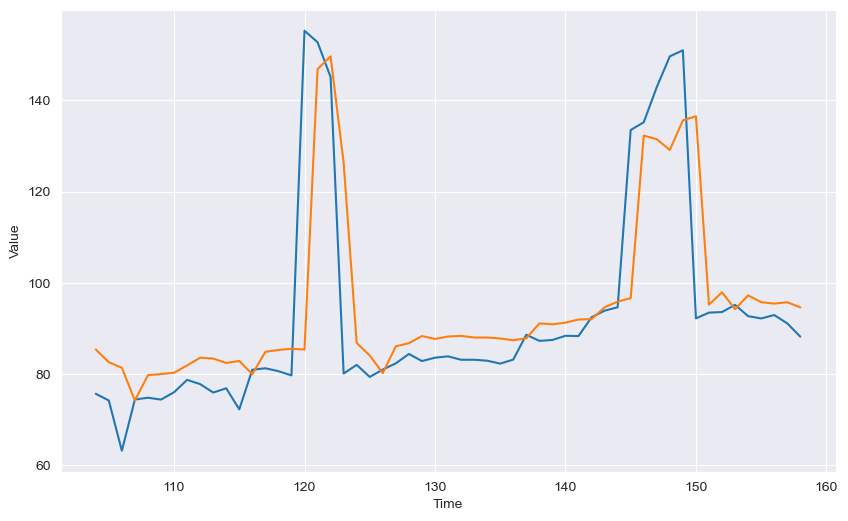

In [128]:
"""沒有搞懂"""
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:] #只有包含spliting time 以前的數據!!!
print("len(forecast_series) = ",len(forecast_series))

# Use the model to predict data points per window size
forecast_series = forecast_series.to_numpy()
print(type(forecast_series))


for time in range(len(forecast_series) - window_size):
    #這裡把要forcast的序列和經緯度座標合併在一起
    forcast_and_location = np.append(forecast_series[time:time + window_size],np.array(coordinates[0]) ) [np.newaxis]
    #這裡把剛剛合併的資料丟到模型裡面做training，然後再把結果append給forcast序列(一個list)
    predict_ = model_baseline.predict(forcast_and_location)
    forecast.append(predict_)
    print("predict_ = ",predict_)

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
print("time_valid = ",time_valid)
print("len(time_valid) = ",len(time_valid))
print("len(results) = ",len(results))
plot_series(time_valid, (x_valid, results))

In [129]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

227.25493
8.319372
